# Transverse profiles, using distance to impact

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot
import hist.intervals

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [3]:
(histStore
    .get(HistogramId("Clus3DRechitsDistanceToImpact_AreaNormalized", clueParams, "data"))
    .getHistogram(HistogramKind.WEIGHTED_PROFILE)[{
        "beamEnergy" : hist.loc(20),
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        "layer" : hist.loc(5),
    }]
    .project("rechits_distanceToImpact")
).variances()

array([2.49918365e-04, 1.32547687e-05, 8.96817222e-07, 1.14860425e-07,
       3.97131120e-08, 2.78962324e-08, 2.52087454e-08, 5.61199732e-08,
       7.42708185e-08, 1.38595773e-07, 2.66950366e-07, 2.62284970e-07,
       9.73375783e-07, 1.29159663e-06, 2.40754145e-06, 3.72371928e-06,
       8.23772810e-06, 3.85836236e-06, 2.47095995e-05, 9.38451414e-06,
       3.94564088e-05, 2.16573426e-06, 3.31815702e-05, 1.04520424e-06,
       4.19304620e-06,            nan,            nan,            nan,
                  nan,            nan])

## Comparing data/simulation

In [4]:
yerr = False
def makePlotMultiDatatype(layer:int, beamEnergy:int, datatypes:list[str]):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    hists = [(histStore
        .get(HistogramId("Clus3DRechitsDistanceToImpact_AreaNormalized", clueParams, datatype))
        .getHistogram(HistogramKind.WEIGHTED_PROFILE)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "layer" : hist.loc(layer),
        }]
        .project("rechits_distanceToImpact")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    plt.figure()
    plt.xlabel("Distance to extrapolated impact point (cm)")
    plt.xlim(0, 6)
    plt.ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    plt.yscale("log")
    
    hep.histplot(hists, label=labels, yerr=yerr)

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"Layer {layer} - $e^+$ {str(beamEnergy)} GeV")
    plt.legend()

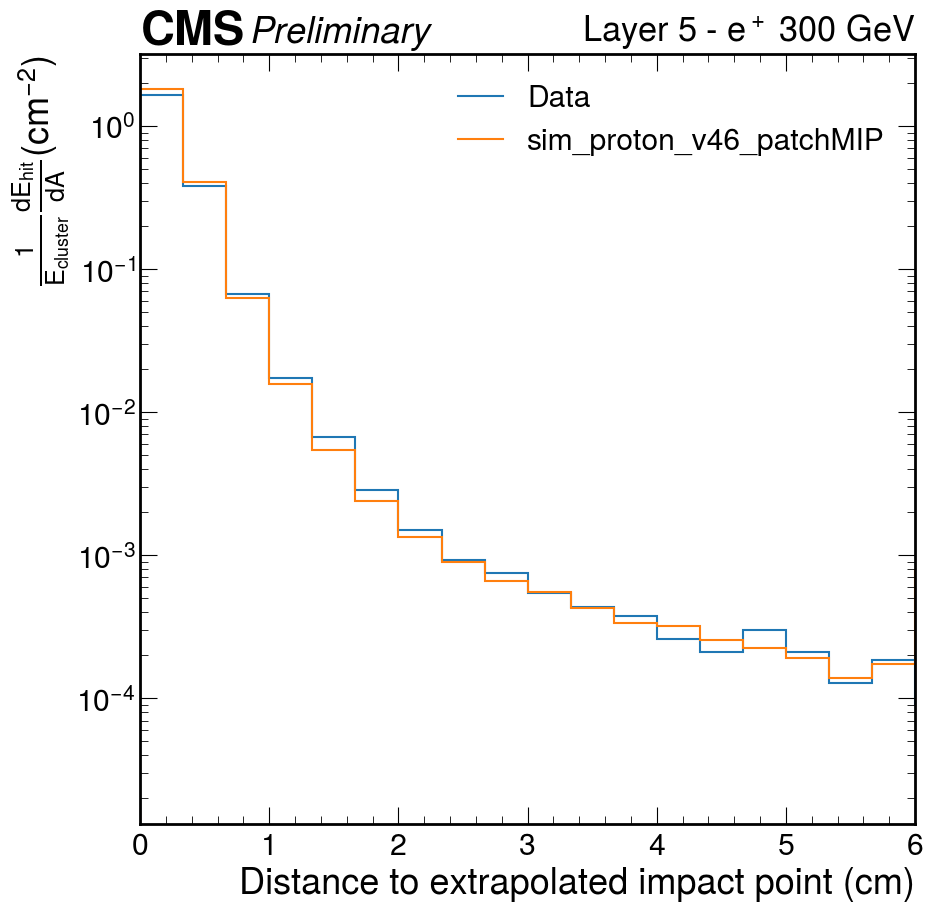

In [5]:
makePlotMultiDatatype(layer=5, beamEnergy=300, datatypes=["data", "sim_proton_v46_patchMIP"])

### Ratio plot

In [6]:
def makePlotRatioDatatype(layer:int, beamEnergy:int, datatypes:list[str]):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    hists = [(histStore
        .get(HistogramId("Clus3DRechitsDistanceToImpact_AreaNormalized", clueParams, datatype))
        .getHistogram(HistogramKind.WEIGHTED_PROFILE)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "layer" : hist.loc(layer),
        }]
        .project("rechits_distanceToImpact")
        ) for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]
    
    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])
    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    hep.histplot(hists, label=labels, yerr=False, ax=main_ax)

    with np.errstate(divide="ignore", invalid="ignore"):
        ratios = hists[0].values() / hists[1].values()
        #ratio_uncert = hist.intervals.ratio_uncertainty(
        #    num=hists[0].values(),
        #    denom=hists[1].values(),
        #    uncertainty_type="poisson", # Assume numerator is Poisson (ignore uncertainty on MC)
        #)
        ratio_uncert = None
        hist.plot.plot_ratio_array(hists[0], ratios, ratio_uncert, subplot_ax, ylim=(0.2,2), ylabel="Ratio")
    
    #plt.gca().xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    #main_ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    #main_ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    main_ax.set_yscale("log")
    main_ax.set_xlabel("")
    main_ax.set_xlim(0, 6)
    subplot_ax.set_xlabel("Distance to extrapolated impact point (cm)")


    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"Layer {layer} - $e^+$ {str(beamEnergy)} GeV", ax=main_ax)
    main_ax.legend()

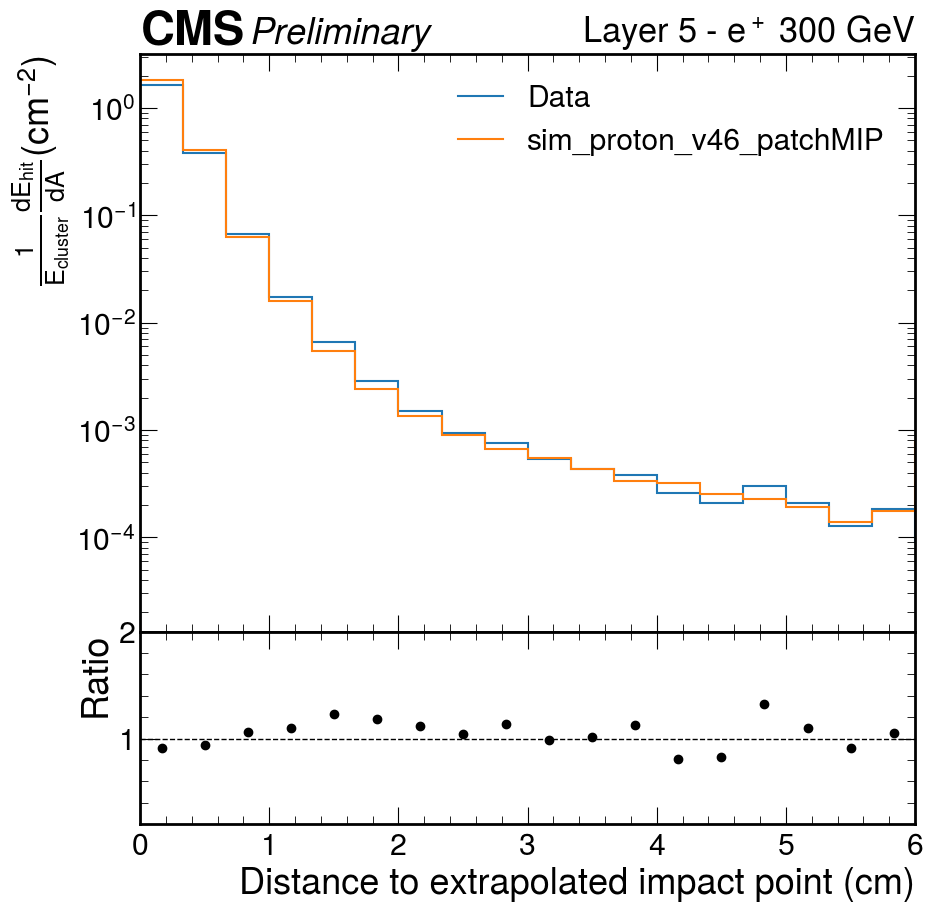

In [7]:
makePlotRatioDatatype(layer=5, beamEnergy=300, datatypes=["data", "sim_proton_v46_patchMIP"])

## Data/Simulation per layer and energy

In [21]:

def makePlotMultiLayerDatatypes(layers:list[int], beamEnergy:int, datatypes:list[str]):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    hists = [(histStore
        .get(HistogramId("Clus3DRechitsDistanceToImpact_AreaNormalized", clueParams, datatype))
        .getHistogram(HistogramKind.WEIGHTED_PROFILE)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "layer" : hist.loc(layer),
        }]
        .project("rechits_distanceToImpact")
        ) for layer in layers for datatype in datatypes]
    labels = [datatypeToLegendMap.get(datatype, datatype) + f" - Layer {layer}" for layer in layers for datatype in datatypes]
    
    plt.figure()
    plt.xlabel("Distance to extrapolated impact point (cm)")
    plt.xlim(0, 6)
    plt.ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    plt.yscale("log")
    
    hep.histplot(hists, label=labels, yerr=yerr)

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV")
    plt.legend()

def makePlotMultiBeamEnergy(layer:int, beamEnergies:list[int], datatypes:list[str]):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    hists = [(histStore
        .get(HistogramId("Clus3DRechitsDistanceToImpact_AreaNormalized", clueParams, datatype))
        .getHistogram(HistogramKind.WEIGHTED_PROFILE)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "layer" : hist.loc(layer),
        }]
        .project("rechits_distanceToImpact")
        ) for beamEnergy in beamEnergies for datatype in datatypes]
    labels = [f"{beamEnergy} GeV - " + datatypeToLegendMap.get(datatype, datatype) for beamEnergy in beamEnergies for datatype in datatypes]
    
    plt.figure()
    plt.xlabel("Distance to extrapolated impact point (cm)")
    plt.xlim(0, 4)
    plt.ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    plt.yscale("log")
    plt.ylim(1e-4, 3)
    
    hep.histplot(hists, label=labels, yerr=yerr)

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"Layer {layer} - $e^+$")
    plt.legend()

In [9]:
for layer in [5, 10, 15, 20, 25]:
    makePlotMultiDatatype(layer=layer, beamEnergy=200, datatypes=["data", "sim_proton_v7", "sim_proton_v46_patchMIP", "sim_noproton_v6"])

FileNotFoundError: [Errno 2] No such file or directory: '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33/cmssw/sim_proton_v7/Clus3DRechitsDistanceToImpact_AreaNormalized.pickle'

## Comparing layers and datatypes

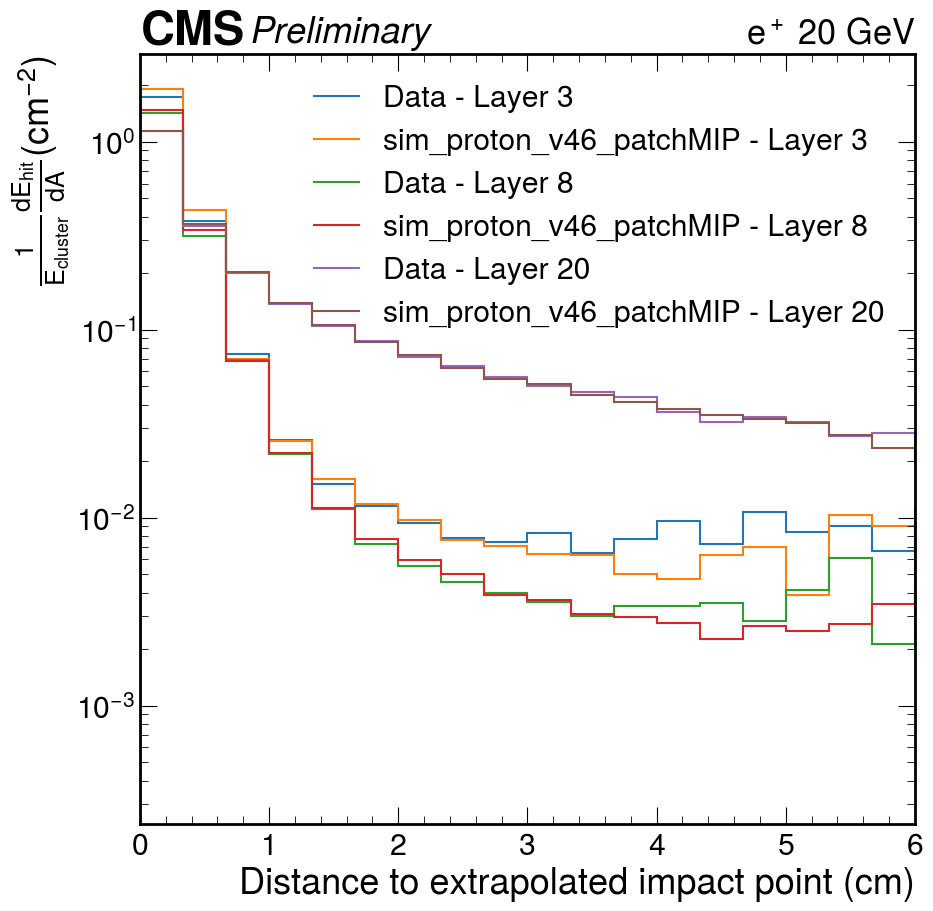

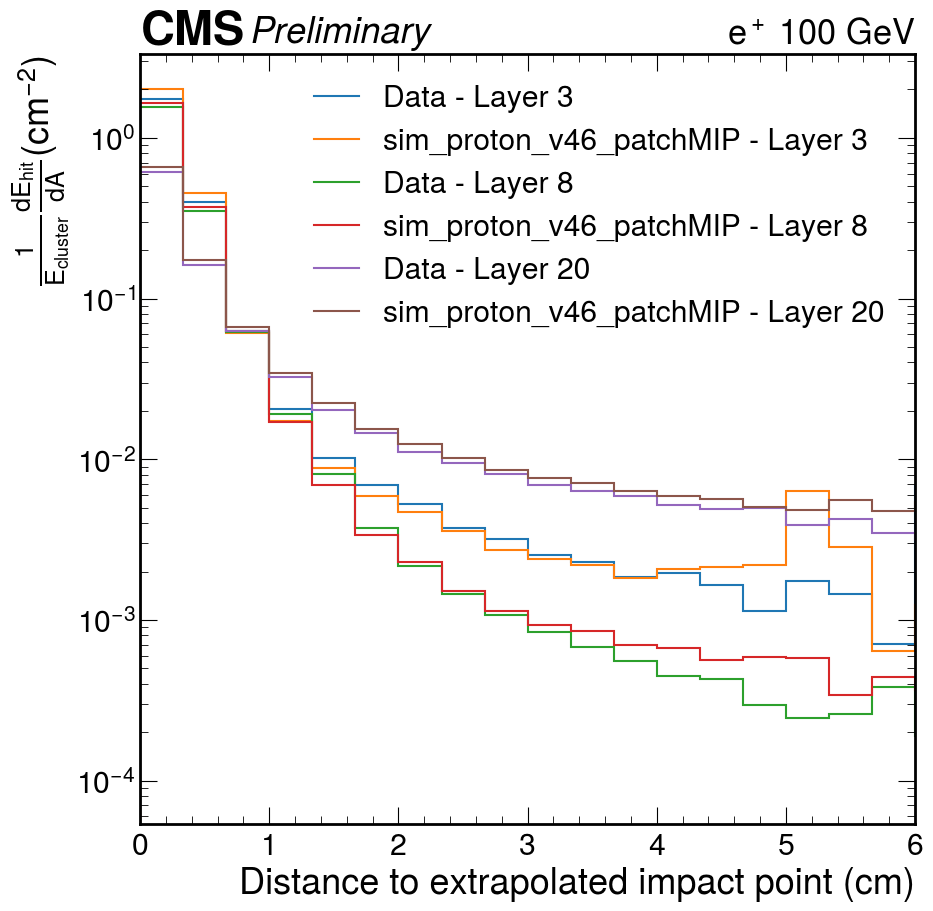

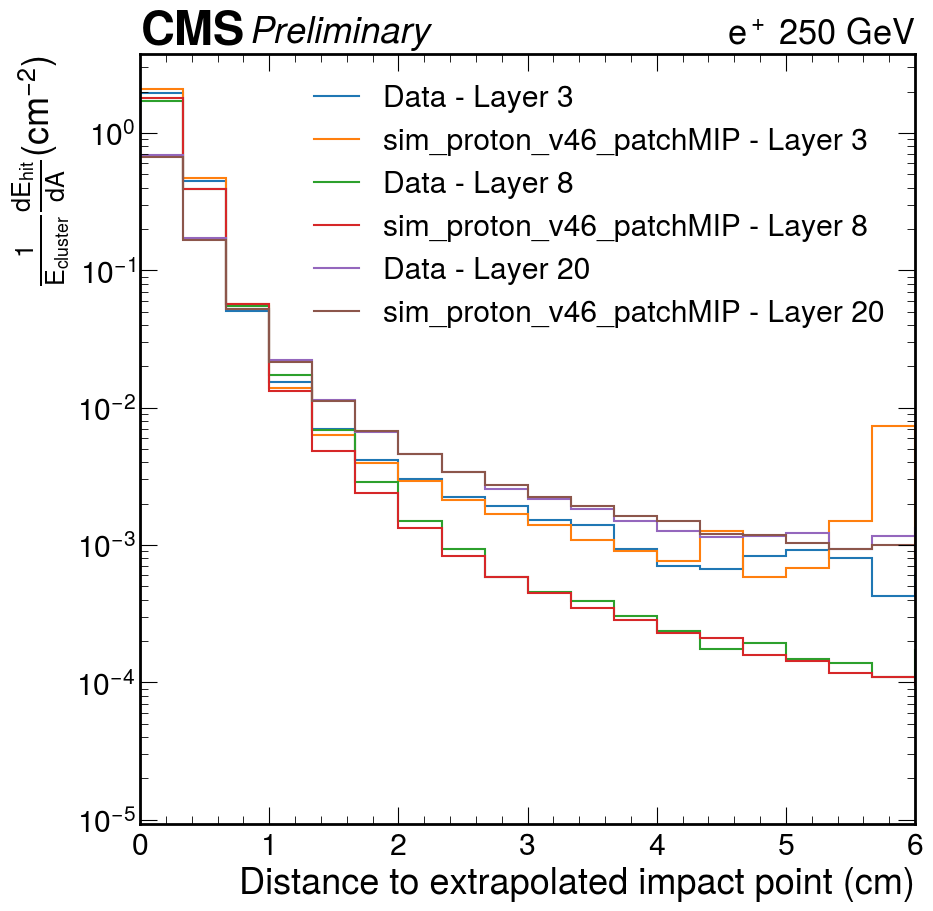

In [10]:
for beamEnergy in [20, 100, 250]:
    makePlotMultiLayerDatatypes(layers=[3, 8, 20], beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"])

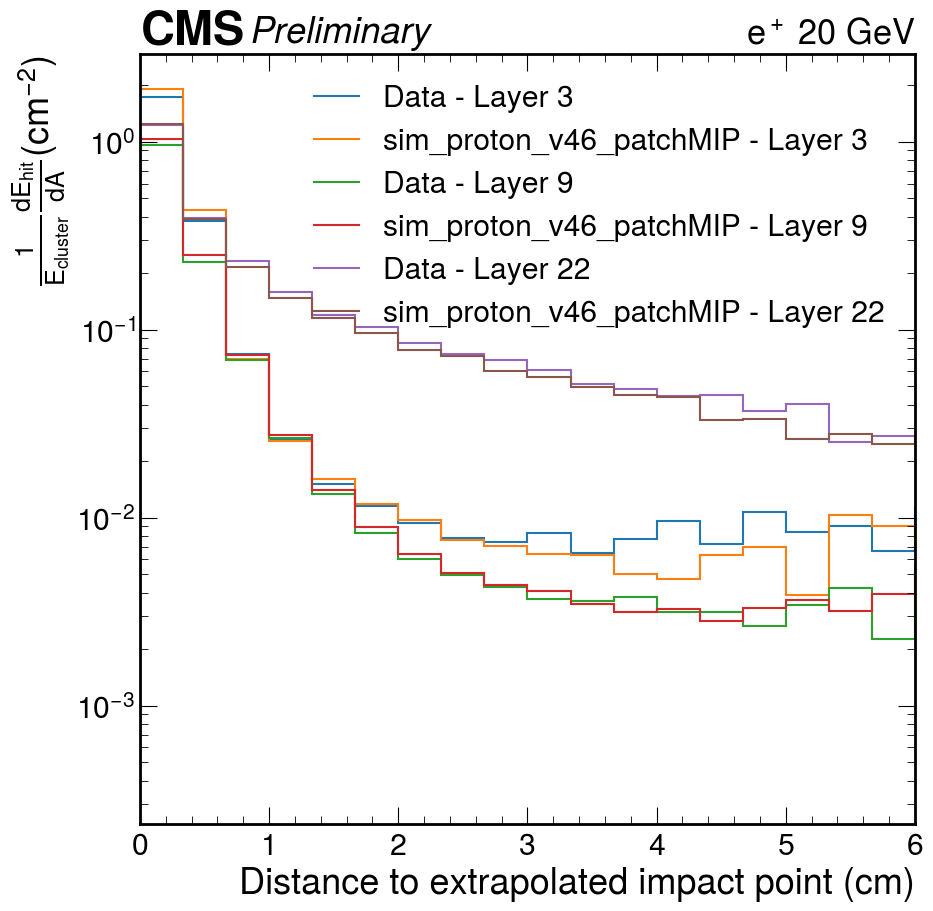

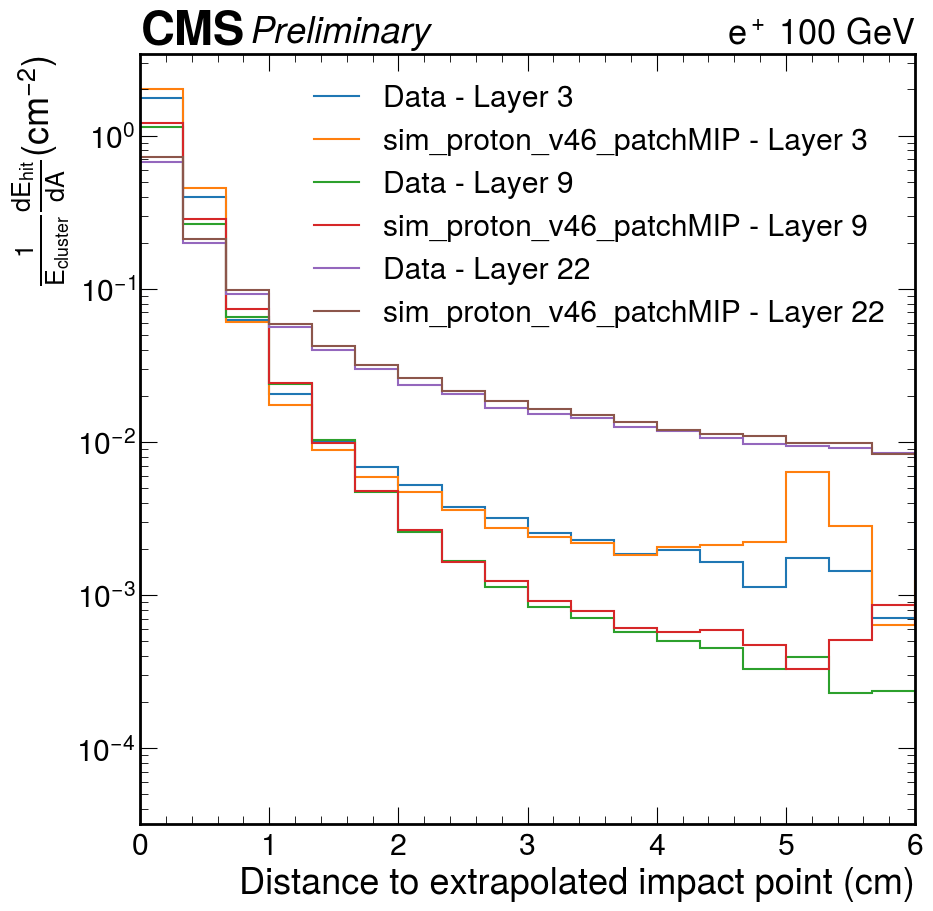

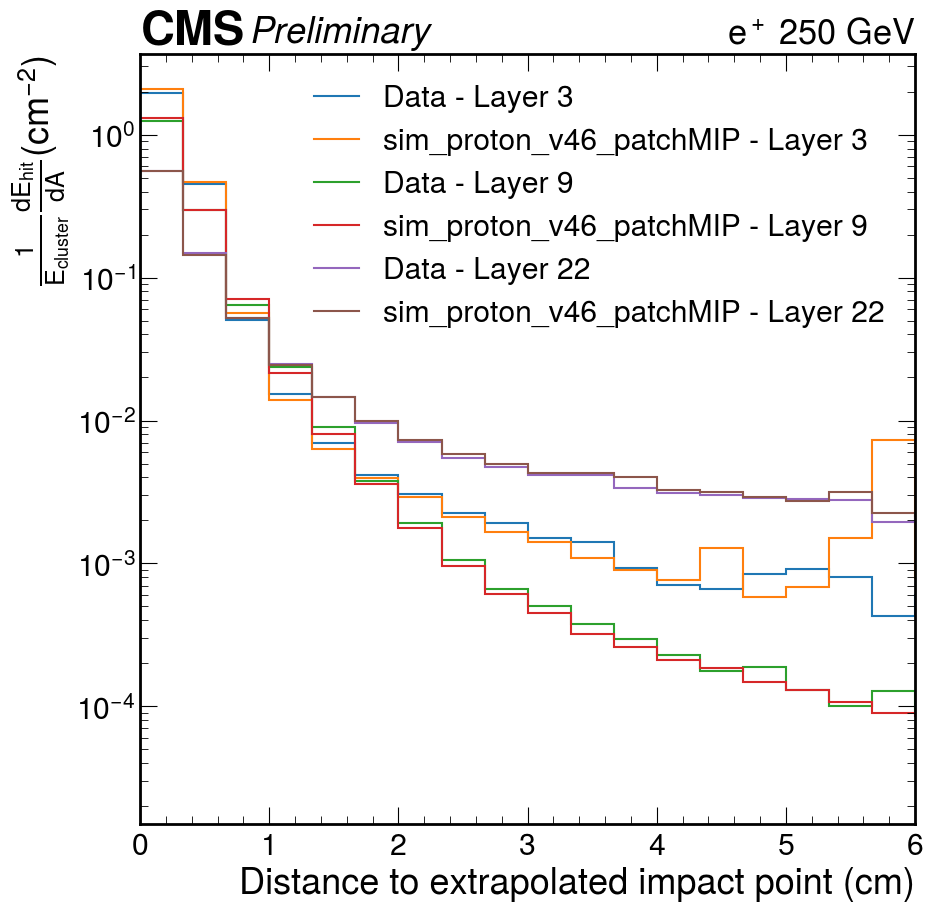

In [11]:
for beamEnergy in [20, 100, 250]:
    makePlotMultiLayerDatatypes(layers=[3, 9, 22], beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"])

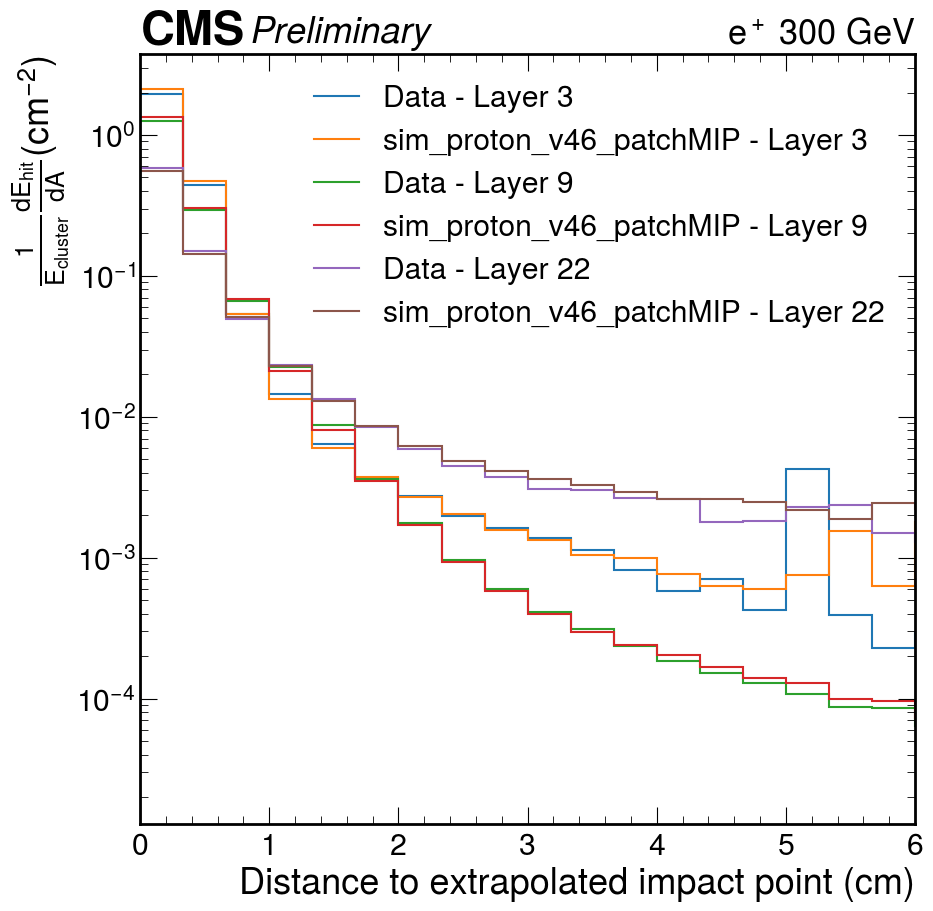

In [12]:
makePlotMultiLayerDatatypes(layers=[3, 9, 22], beamEnergy=300, datatypes=["data", "sim_proton_v46_patchMIP"])

## Comparing energies

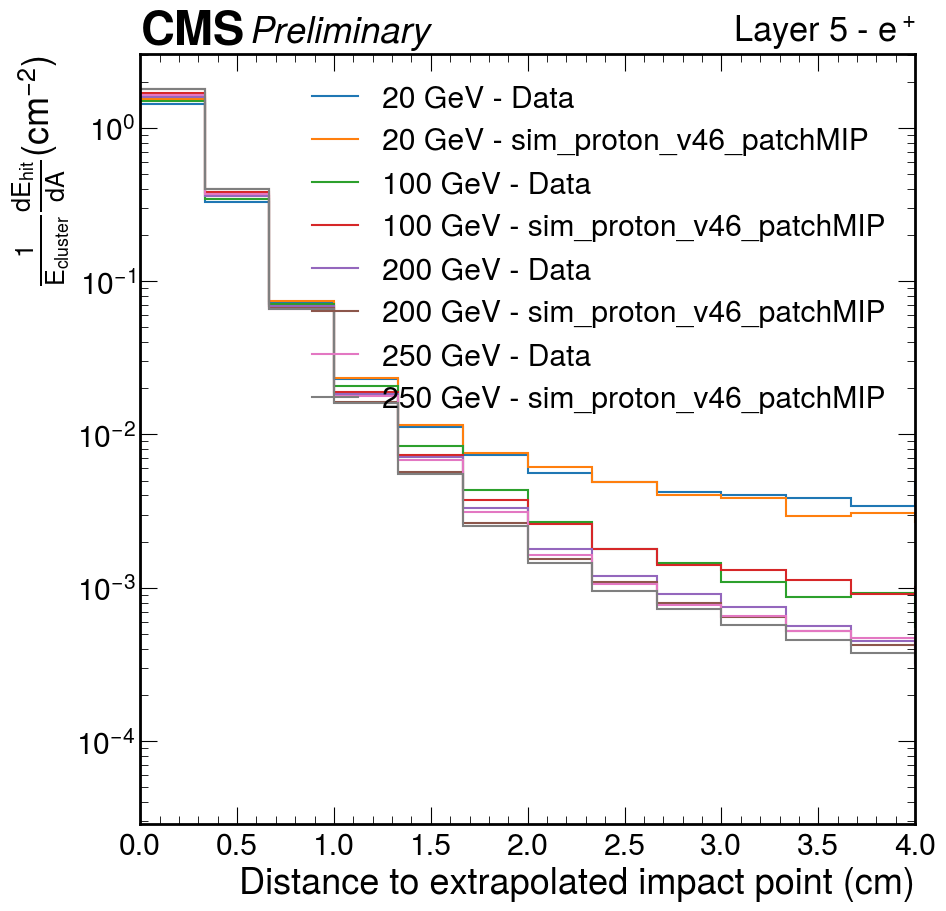

In [13]:
makePlotMultiBeamEnergy(layer=5, beamEnergies=[20, 100, 200, 250], datatypes=["data", "sim_proton_v46_patchMIP"])

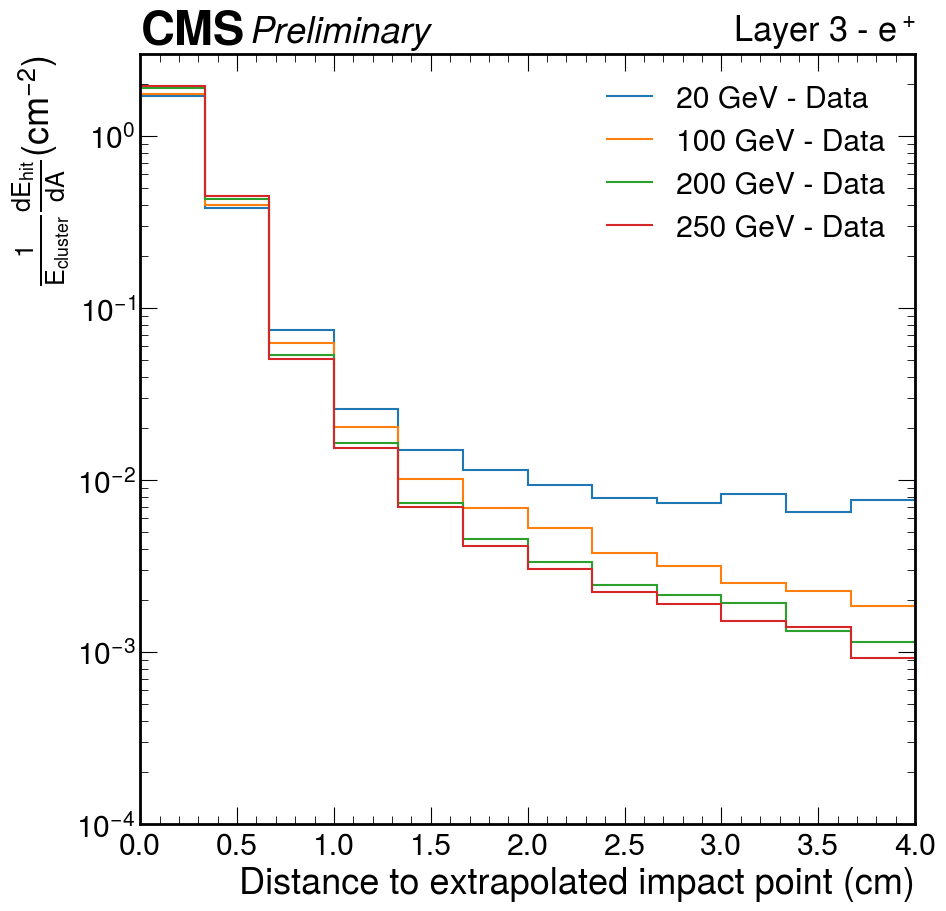

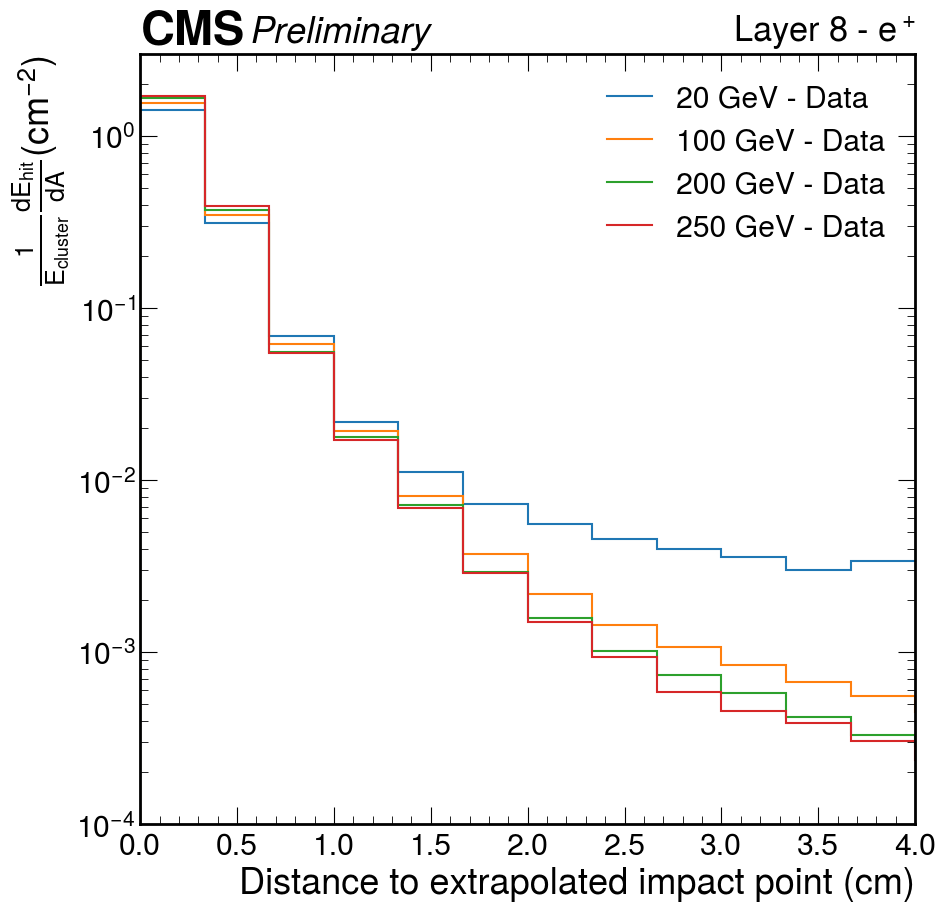

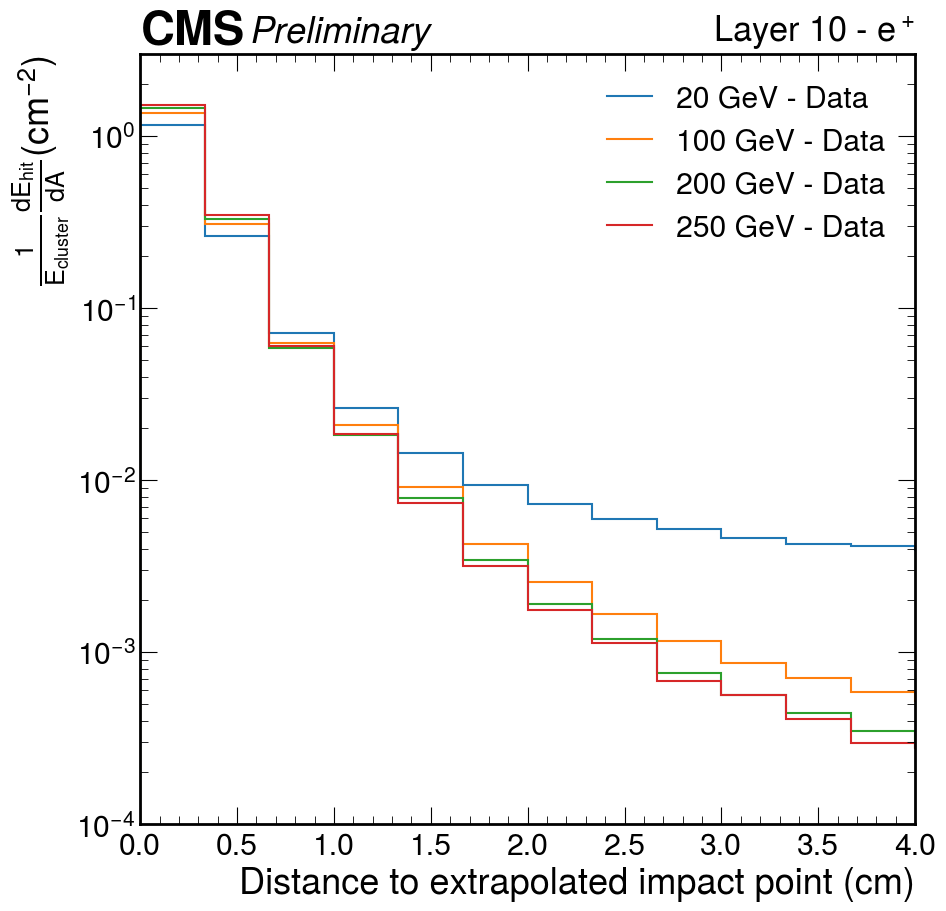

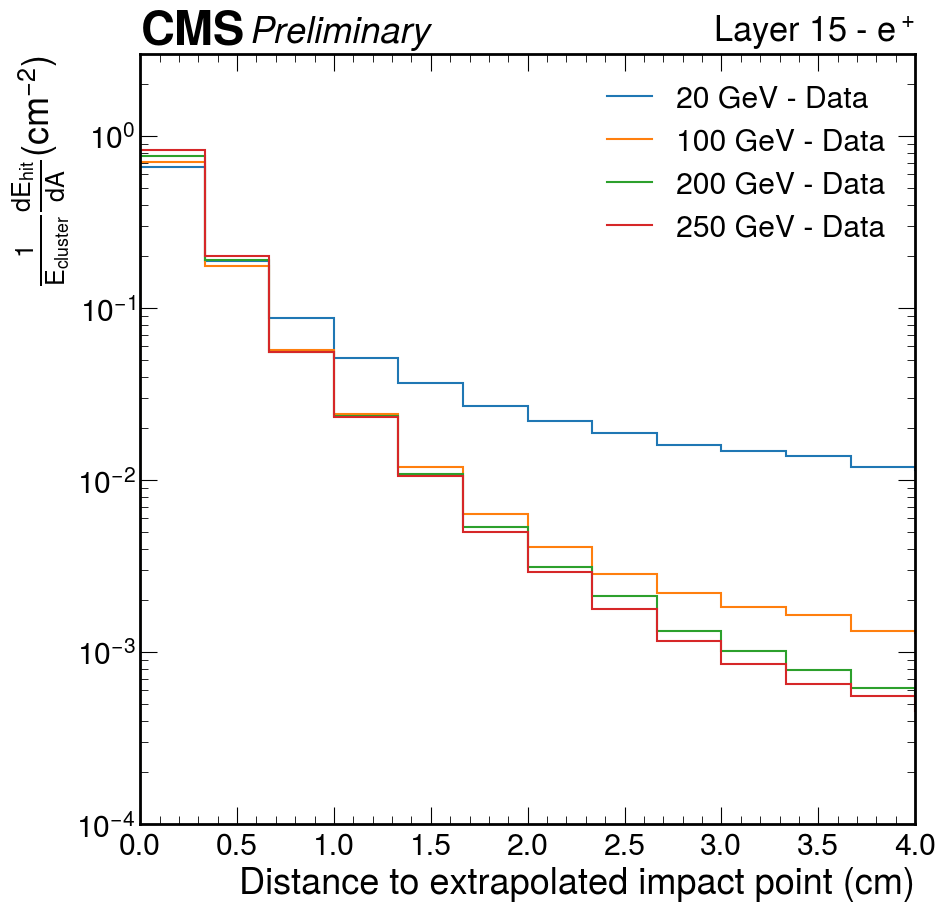

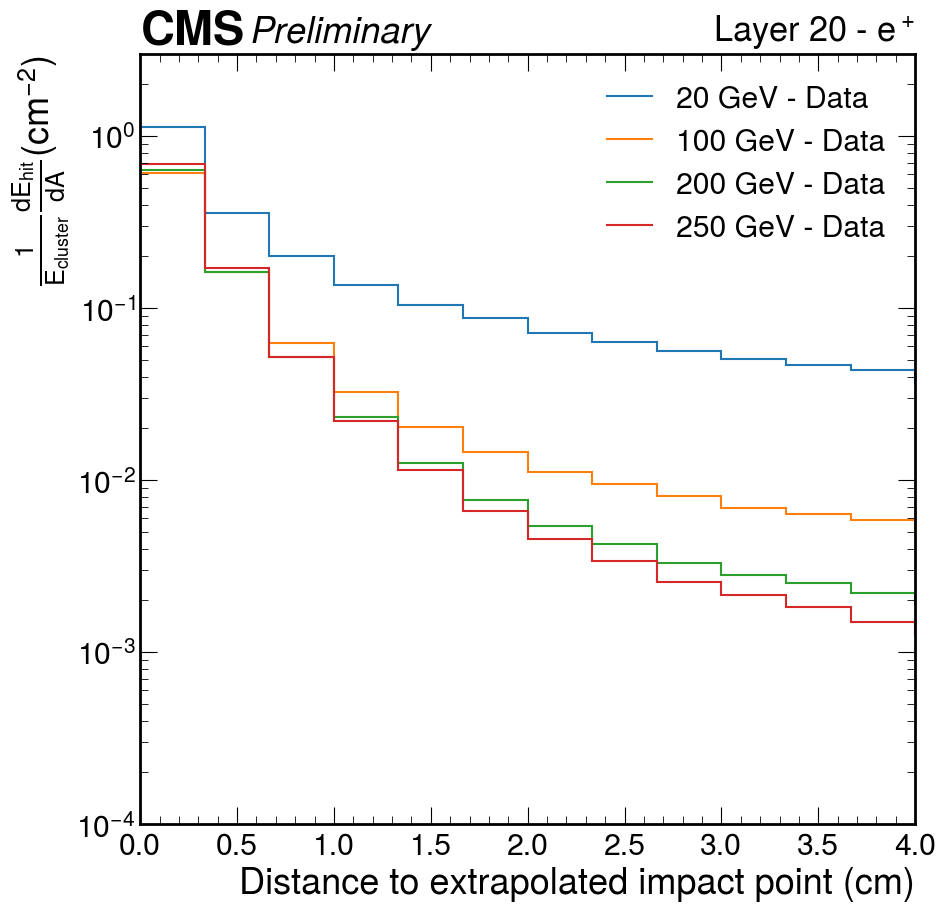

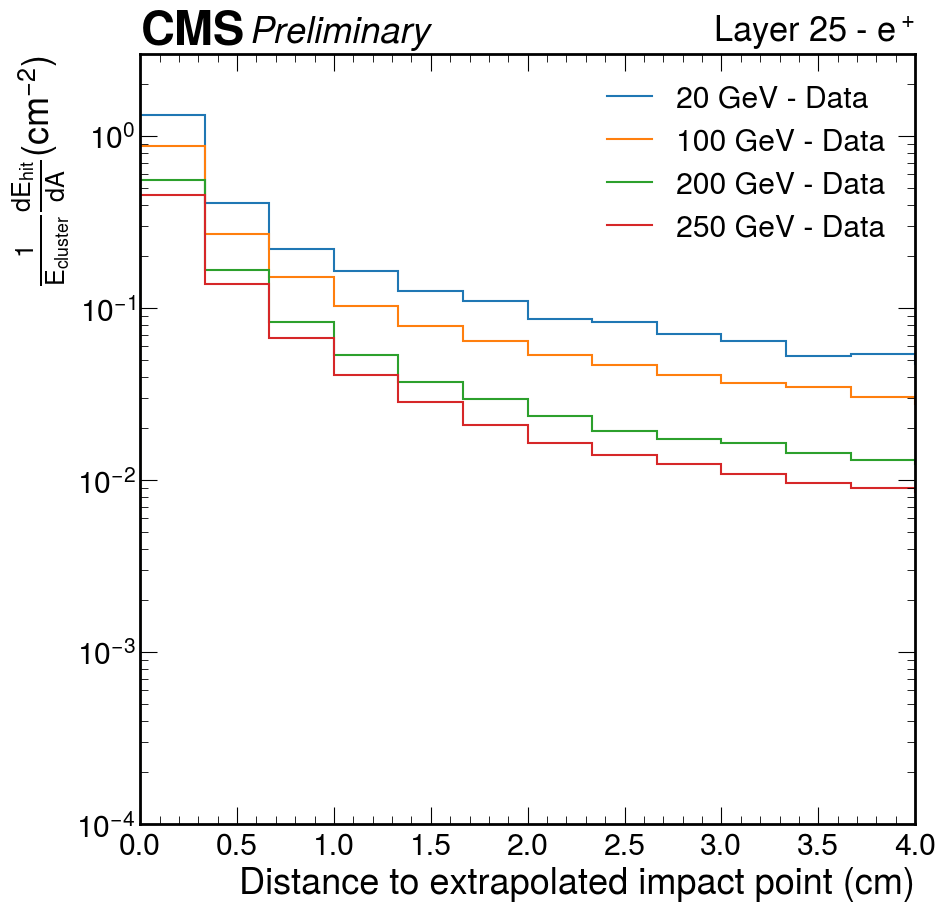

In [22]:
for layer in [3, 8, 10, 15, 20, 25]:
    makePlotMultiBeamEnergy(layer=layer, beamEnergies=[20, 100, 200, 250], datatypes=["data"])

## Comparing rechits/CLUE/CLUE3D

In [15]:
def makePlotComparisonRechitsClueClue3D(layers:list[int], beamEnergy:int, datatype:str):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    histogramNames = {"RechitsDistanceToImpact_AreaNormalized" : "Rechits",
        "Clus2DRechitsDistanceToImpact_AreaNormalized" : "Layer clusters",
        "Clus3DRechitsDistanceToImpact_AreaNormalized" : "CLUE3D"}
    hists = []
    for histogramName in histogramNames:
        if histogramName == "Clus3DRechitsDistanceToImpact_AreaNormalized":
            customProj = {"mainOrAllTracksters" : hist.loc("mainTrackster")}
        else:
            customProj = {}
        hists += [(histStore
            .get(HistogramId(histogramName, clueParams, datatype))
            .getHistogram(HistogramKind.WEIGHTED_PROFILE)[customProj | {
                "beamEnergy" : hist.loc(beamEnergy),
                # Project on clus3D_size
                "layer" : hist.loc(layer),
            }]
            .project("rechits_distanceToImpact")
            ) for layer in layers]
    labels = [f"{histogramLabel} - Layer {layer}" for layer in layers for histogramLabel in histogramNames.values()]
    #return hists
    plt.figure()
    plt.xlabel("Distance to extrapolated impact point (cm)")
    plt.xlim(0, 6)
    plt.ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    plt.yscale("log")
    
    hep.histplot(hists, label=labels, yerr=yerr)

    if "data" == datatype:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV")
    plt.legend()

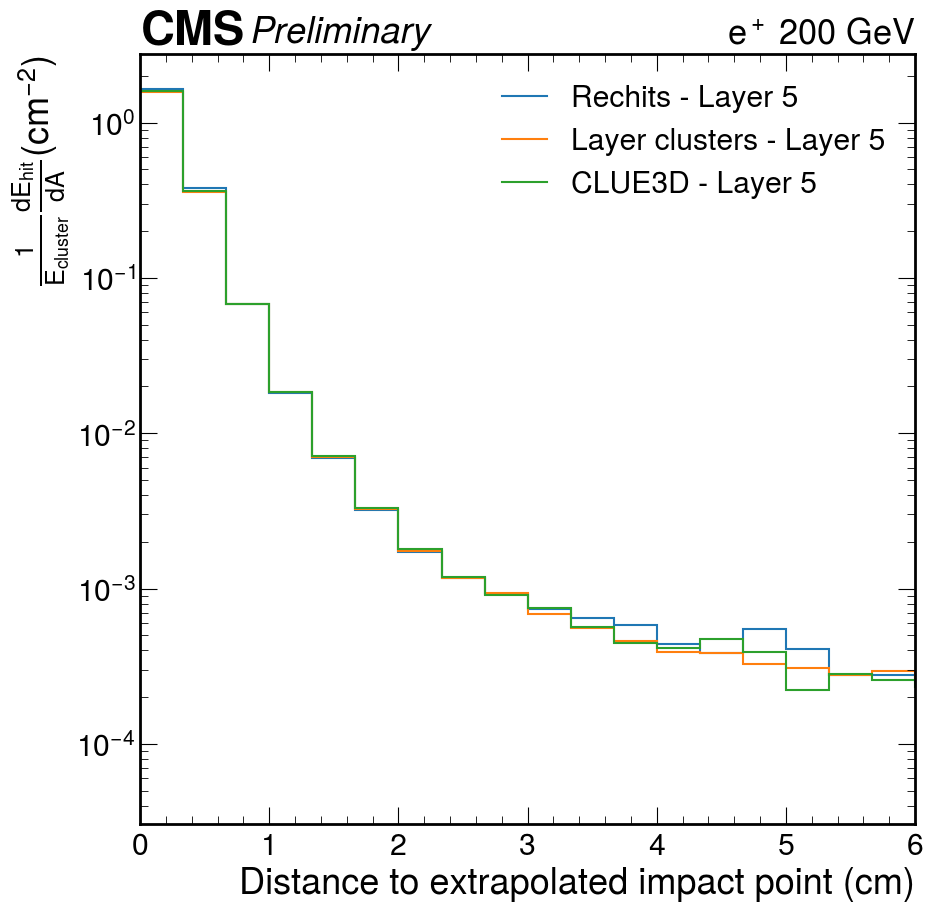

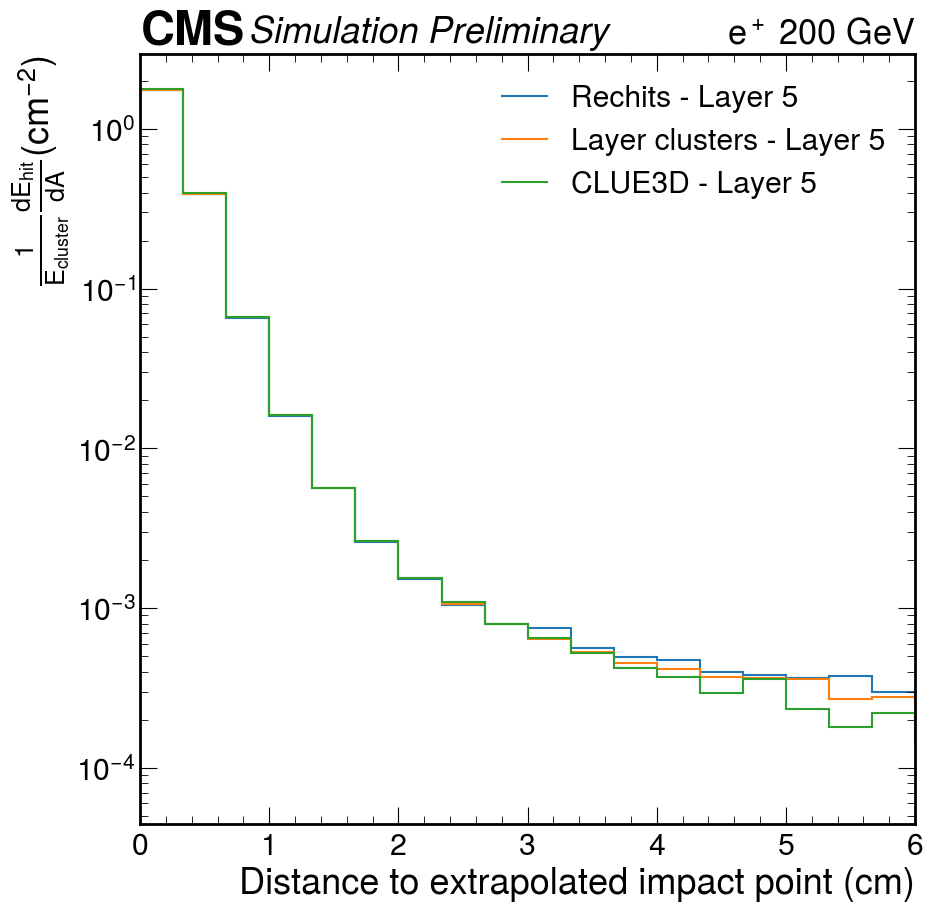

In [16]:
makePlotComparisonRechitsClueClue3D(layers=[5], beamEnergy=200, datatype="data")
makePlotComparisonRechitsClueClue3D(layers=[5], beamEnergy=200, datatype="sim_proton_v46_patchMIP")